In [7]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src/features')))

import re
import pytz
import torch
import joblib
import pandas as pd
import numpy as np
import warnings

from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split


from process_features import preprocess_data
from forests import ForestKind, TaskType
from naf_model import NeuralAttentionForest, NAFParams

from IPython.core.debugger import set_trace

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
path = '../../gsoc_incidents_raw3.parquet'
df = pd.read_parquet(path)

df['target'] = df['Вердикт'].apply( lambda x: True if x == 'False Positive' else (pd.NA if x == 'Не указан' else False))
df = df[df['target'].notnull()]
df['target'] = df['target'].astype(float)
df = df[::1000]

y = df['target'].astype(float).to_numpy()
X = df.drop(columns=['target'])

used_columns = pd.read_csv('../src/features/used_columns.csv')

X = X[used_columns['column'].to_numpy()]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train = preprocess_data(X_train, '../data/transform_data_pipeline.pkl')

In [11]:
params = NAFParams(
    kind=ForestKind.RANDOM,
    task=TaskType.CLASSIFICATION,
    mode='end_to_end',
    loss='cross_entropy',
    n_epochs=80,
    lr=0.01,
    lam=0.0,
    target_loss_weight=1.0,
    hidden_size=16,
    gpu=True,
    gpu_device = 3,
    n_layers=1,
    forest=dict(
        n_estimators=100,
        min_samples_leaf=1,
        n_jobs=-1
    ),
    random_state=67890
)
model = NeuralAttentionForest(params)

In [12]:
model.fit(X_train, y_train)

Start fitting Random forest


Random forest fit time: 0.200835
Random forest apply time: 0.042144
Generating leaves data
bytecode dump:
>          0	NOP(arg=None, lineno=27)
           2	RESUME(arg=0, lineno=27)
           4	LOAD_FAST(arg=1, lineno=37)
           6	LOAD_METHOD(arg=0, lineno=37)
          28	PRECALL(arg=0, lineno=37)
          32	CALL(arg=0, lineno=37)
          42	STORE_FAST(arg=2, lineno=37)
          44	LOAD_FAST(arg=2, lineno=38)
          46	LOAD_CONST(arg=1, lineno=38)
          48	BINARY_OP(arg=0, lineno=38)
          52	STORE_FAST(arg=3, lineno=38)
          54	LOAD_FAST(arg=1, lineno=39)
          56	LOAD_ATTR(arg=1, lineno=39)
          66	LOAD_CONST(arg=1, lineno=39)
          68	BINARY_SUBSCR(arg=None, lineno=39)
          78	STORE_FAST(arg=4, lineno=39)
          80	LOAD_FAST(arg=0, lineno=40)
          82	LOAD_ATTR(arg=1, lineno=40)
          92	LOAD_CONST(arg=2, lineno=40)
          94	BINARY_SUBSCR(arg=None, lineno=40)
         104	STORE_FAST(arg=5, lineno=40)
         106	LOAD_GLOBA

matplotlib data path: /home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data
CONFIGDIR=/raid/agubarev/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/raid/agubarev/.cache/matplotlib
Using fontManager instance from /raid/agubarev/.cache/matplotlib/fontlist-v390.json
cuda:3
0


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(198)_optimize_weights_end_to_end()
    196 
    197         # device, precision
--> 198         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    199         use_fp16 = getattr(self.params, 'use_fp16', False)
    200         dtype = torch.float16 if use_fp16 else torch.float32



1.2


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(433)_get_leaf_data_segments_gpu()
    431         set_trace()
    432 
--> 433         for si in tqdm(range(0, n_samples, sample_batch_size), 'leafs'):
    434             sb = min(sample_batch_size, n_samples - si)
    435             leaf_ids_batch = torch.from_numpy(leaf_ids[si:si + sb])  # (sb, n_trees)



leafs: 100%|██████████| 1/1 [00:00<00:00, 47.96it/s]
1.3


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(468)_get_leaf_data_segments_gpu()
    466         set_trace()
    467 
--> 468         return result
    469 
    470 



2


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(211)_optimize_weights_end_to_end()
    209         set_trace()
    210 
--> 211         if self.params.task == TaskType.CLASSIFICATION:
    212             y_tensor = torch.tensor(y_orig, dtype=torch.long)
    213         else:



3


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(222)_optimize_weights_end_to_end()
    220 
    221         # dataloader
--> 222         dataset = TensorDataset(X_tensor, y_tensor, indices)
    223         loader = DataLoader(dataset, batch_size=1024, shuffle=True)
    224 



4


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(229)_optimize_weights_end_to_end()
    227 
    228         # background data
--> 229         dense_y = self.training_y.toarray() if scipy.sparse.issparse(self.training_y) else self.training_y
    230         background_X_cpu = torch.tensor(self.training_xs, dtype=dtype)
    231         background_y_cpu = torch.tensor(dense_y, dtype=dtype)



5


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(240)_optimize_weights_end_to_end()
    238 
    239         # loss function
--> 240         optim = torch.optim.AdamW(self.nn.parameters(), lr=self.params.lr)
    241         loss_fn = self._make_loss()
    242         n_epochs = self.params.n_epochs



6


> /raid/agubarev/naf/NAF/naf_optimize_gpu/src/naf_model.py(254)_optimize_weights_end_to_end()
    252 
    253         # learn
--> 254         if self.params.lam == 0.0:
    255             for epoch in trange(n_epochs, desc="Training (no reconstruction)"):
    256                 epoch_losses = []



Training (no reconstruction): 100%|██████████| 80/80 [00:20<00:00,  3.99it/s]
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
findfont: score(FontEntry(fname='/home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/

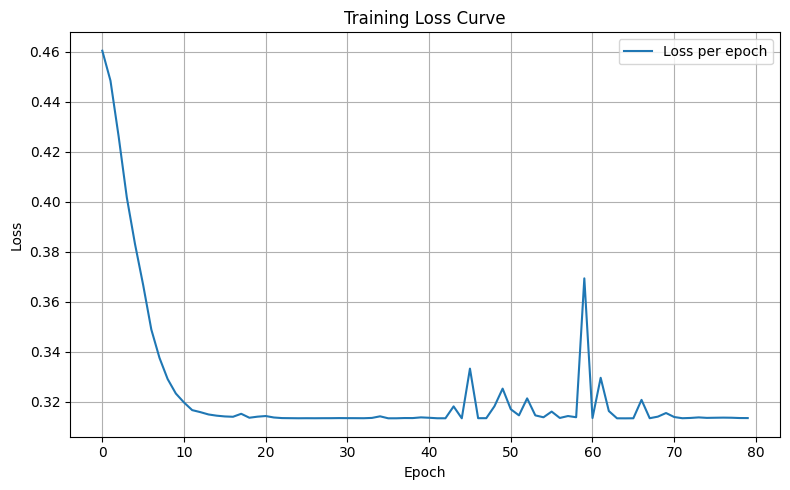

In [13]:
model.optimize_weights(X_train, y_train)

In [10]:
for name, value in model.__dict__.items():
    print(f"{name}: {type(value)}")

params: <class 'naf.naf_model.NAFParams'>
forest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
run_agent: <class 'NoneType'>
onehot_encoder: <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
training_xs: <class 'numpy.ndarray'>
training_y: <class 'scipy.sparse._csr.csr_matrix'>
training_leaf_ids: <class 'numpy.ndarray'>
leaf_sparse: <class 'numpy.ndarray'>
n_trees: <class 'int'>
nn: <class 'naf.naf_nn.NAFNetwork'>
device: <class 'torch.device'>


In [15]:
def save_model_fields(model, path: str):
    os.makedirs(path, exist_ok=True)

    for key, value in model.__dict__.items():
        try:
            joblib.dump(value, os.path.join(path, f"{key}.pkl"))
            print(key)
        except Exception as e:
            print(f"❌ Failed to save {key}: {e}")

In [13]:
def load_model_fields(cls, path: str):
    obj = cls.__new__(cls)  # создать объект без вызова __init__
    for file in tqdm(os.listdir(path), desc='load'):
        if file.endswith(".pkl"):
            key = file[:-4]
            try:
                value = joblib.load(os.path.join(path, file))
                setattr(obj, key, value)
            except Exception as e:
                print(f"❌ Failed to load {key}: {e}")
    return obj

In [14]:
model_loaded = load_model_fields(NeuralAttentionForest, "model")

load:   0%|          | 0/11 [00:00<?, ?it/s]

load: 100%|██████████| 11/11 [00:20<00:00,  1.85s/it]

❌ Failed to load leaf_sparse: EOF: reading array data, expected 262144 bytes got 0


In [15]:
X_test = preprocess_data(X_test, '../data/transform_data_pipeline.pkl')

In [17]:
y_proba = model.predict(X_test)[:, 1]
#y_proba = model.predict(X_test)

Predicting: 100%|██████████| 1/1 [00:00<00:00, 210.05it/s]


In [18]:


thresholds = np.linspace(0, 1, 100)

beta = 2

max_f1_vals = []
max_f1_args = []

f1_scores = []

y_true = np.array([1 if label == 0 else 0 for label in y_test])
for thr in thresholds:
    y_pred = (np.array([1 - score for score in y_proba]) >= 1 - thr).astype(int)
    f1 = fbeta_score(y_true, y_pred, beta=beta)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)
max_f1 = f1_scores.max()
arg_f1 = f1_scores.argmax()

print(f'max F2 = {max_f1:.3f}, threshold = {arg_f1 / 100}')

max F2 = 0.603, threshold = 0.99


In [30]:
!python NAF/naf/changes_test.py

⏳ data loading...
✅ data loaded successfully...
⏳ gpu model fit...
Start fitting Random forest
Random forest fit time: 0.272776
Random forest apply time: 0.033510
Generating leaves data
bytecode dump:
>          0	NOP(arg=None, lineno=27)
           2	RESUME(arg=0, lineno=27)
           4	LOAD_FAST(arg=1, lineno=37)
           6	LOAD_METHOD(arg=0, lineno=37)
          28	PRECALL(arg=0, lineno=37)
          32	CALL(arg=0, lineno=37)
          42	STORE_FAST(arg=2, lineno=37)
          44	LOAD_FAST(arg=2, lineno=38)
          46	LOAD_CONST(arg=1, lineno=38)
          48	BINARY_OP(arg=0, lineno=38)
          52	STORE_FAST(arg=3, lineno=38)
          54	LOAD_FAST(arg=1, lineno=39)
          56	LOAD_ATTR(arg=1, lineno=39)
          66	LOAD_CONST(arg=1, lineno=39)
          68	BINARY_SUBSCR(arg=None, lineno=39)
          78	STORE_FAST(arg=4, lineno=39)
          80	LOAD_FAST(arg=0, lineno=40)
          82	LOAD_ATTR(arg=1, lineno=40)
          92	LOAD_CONST(arg=2, lineno=40)
          94	BINAR